Random Clifford circuit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Pauli, Clifford, SparsePauliOp, Operator, Statevector
from qiskit import QuantumCircuit

At every odd (even) time step a set of SWAP gates is applied on the odd (even) bonds, with probability 0 ≤ p ≤ 1 on each bond. Then, a set of CNOT gates is applied on a fraction 0 ≤ r ≤ 1/2 of all the bonds. The bonds are chosen such that only configurations where no two bonds share a site are allowed and each such configuration is equally probable. The role of each qubit (control or target) is chosen randomly and independently for each pair of sites.

In [2]:

def create_circuit_layers(n_qubits, time, p, r):
    """
    Generate a list of QuantumCircuits, one per time step, implementing
    the random SWAP + CNOT dynamics as in Keselman et al.

    Returns:
        layers: list of QuantumCircuit of depth 1 (one SWAP+CNOT layer each)
    """
    assert 0 <= r <= 0.5, "r must be in [0, 0.5]"
    assert n_qubits >= 2, "At least 2 qubits are needed"

    layers = []
    for t_step in range(time):
        qc = QuantumCircuit(n_qubits)
        parity = t_step % 2

        # SWAP layer
        for i in range(parity, n_qubits - 1, 2):
            if np.random.rand() < p:
                qc.swap(i, i + 1)

        # CNOT layer
        all_bonds = [(i, i + 1) for i in range(0, n_qubits - 1, 2)] + \
                    [(i, i + 1) for i in range(1, n_qubits - 1, 2)]
        np.random.shuffle(all_bonds)

        selected = []
        used = set()
        max_cnots = int(r * (n_qubits - 1))
        for (a, b) in all_bonds:
            if a not in used and b not in used:
                if len(selected) >= max_cnots:
                    break
                selected.append((a, b))
                used.update([a, b])

        for a, b in selected:
            if np.random.rand() < 0.5:
                qc.cx(a, b)
            else:
                qc.cx(b, a)

        layers.append(qc)
    return layers

In [3]:
def U_at_time(layers, time):
    if not (0 <= time < len(layers)):
        raise IndexError("time fuera de rango")
    U = Operator(layers[0])
    for idx in range(1, time+1):
        U = Operator(layers[idx]) @ U

    return U

def Clifford_at_time(layers, time, n_qubits):
    if not (0 <= time < len(layers)):
        raise IndexError("t fuera de rango")
    
    qc = QuantumCircuit(n_qubits)
    
    for layer in layers[:time+1]:
        qc.compose(layer, inplace=True)   

    return Clifford(qc)

def satate_at_time(layers, time, n_qubits):
    if not (0 <= time < len(layers)):
        raise IndexError("t fuera de rango")
    
    qc = QuantumCircuit(n_qubits)
    
    for layer in layers[:time+1]:
        qc.compose(layer, inplace=True)    
    
    psi = Statevector.from_instruction(qc)
    return psi

def heisenberg_evolve_pauli(n_qubits, layers, init_site, time):
    """
    Evolve the operator W_i(0) = Z_i / sqrt(2) in Heisenberg picture
    through each layer, returning a list of SparsePauliOp objects.
    """
    # initial Pauli string: Z on init_site, I elsewhere
    z_pauli = ['I'] * n_qubits
    z_pauli[init_site] = 'Z'
    W = SparsePauliOp(Pauli(''.join(reversed(z_pauli))), 1/np.sqrt(2))
    
    U = U_at_time(layers, time)
    
    W_mat = U.adjoint().data @ W.to_matrix() @ U.data
    W = SparsePauliOp.from_operator(Operator(W_mat))
    
    return W


def compute_Cij(W: SparsePauliOp, j: int, n_qubits: int, state):
    """
    Compute C_{i,j}(t) 
    """
    # Build V_j
    x_pauli = ['I'] * n_qubits
    x_pauli[j] = 'X'
    V = SparsePauliOp(Pauli(''.join(reversed(x_pauli))), 1/np.sqrt(2))

    # comm = Pauli.commutes(W, V)
    # Convert to matrices
    Wm = W.to_matrix()
    Vm = V.to_matrix()

    comm = Wm @ Vm - Vm @ Wm
    comm2 = comm @ comm
    
    return state.expectation_value(comm2) 


def compute_iOTOC(n_qubits, time, layers, init_site):
    """
    Main function: builds layers, evolves W_i, and computes f(t) for all t.
    Returns:
        times: list of t=0..time
        f_vals: list of iOTOC values
    """
    
    f_vals = []
    for t in range(time):
        state = satate_at_time(layers, t, n_qubits)
        Wt = heisenberg_evolve_pauli(n_qubits, layers, init_site, t)
        C_vals = [-compute_Cij(Wt, j, n_qubits, state) for j in range(n_qubits)]
        f_vals.append(sum(C_vals))
    return list(range(len(f_vals))), np.real(f_vals), layers


In [4]:
def count_paulis(pauli_str):
    """
    Count the number of Z Pauli operators in a given string.
    """
    count = 0
    for p in pauli_str:
        if p == Pauli('Z'):
            count += 1
    return count

def compute_iOTOC_counts(n_qubits, time, layers, init_site):

    """
    Compute the iOTOC for a given time, p, and r, counting the number of Z paulis operators.
    """
    #layers = create_circuit_layers(n_qubits, time, p, r)
    # Build V_j
    Z_pauli_initial = ['I'] * n_qubits
    Z_pauli_initial[init_site] = 'Z'
    W = Pauli("".join(Z_pauli_initial))
    
    counts = []
    for t in range(time):
        U = Clifford_at_time(layers, t, n_qubits)
        print
        Wt = W.evolve(U)  # Evolve the Pauli operator with U
        # Count the number of Z Pauli operators in Wt
        count = count_paulis(Wt)
        counts.append(count)
        
    return list(range(len(counts))), counts

Execution time for compute_iOTOC_counts: 37.2228 seconds


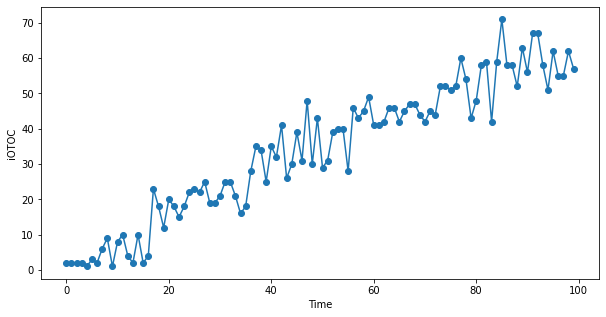

In [29]:
import time

L = 120
T = 100  
p = 0.9
r = 0.5

layers = create_circuit_layers(L,T, p, r)

# start_time1 = time.time()
# iOTOC_times1, iOTOC_vals1, layers = compute_iOTOC(L, T, layers, init_site=L//2)
# end_time1 = time.time()
# print(f"Execution time for compute_iOTOC: {end_time1 - start_time1:.4f} seconds")    
    
# plt.figure(figsize=(10, 8))
# plt.plot(iOTOC_times1, iOTOC_vals1, marker='o')
# plt.xlabel('Time')
# plt.ylabel('iOTOC')
# plt.show()

start_time2 = time.time()
iOTOC_times2, iOTOC_vals2 = compute_iOTOC_counts(L, T, layers, init_site=L//2)
end_time2 = time.time()
print(f"Execution time for compute_iOTOC_counts: {end_time2 - start_time2:.4f} seconds")

plt.figure(figsize=(10, 5))
plt.plot(iOTOC_times2, iOTOC_vals2, marker='o')
plt.xlabel('Time')
plt.ylabel('iOTOC')
plt.show()

